In [7]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import math
from PIL import Image
import cv2
import torch
import sklearn
from sklearn import preprocessing
from collections import Counter
from sklearn.model_selection import train_test_split
from mtcnn.mtcnn import MTCNN
from skimage.util import random_noise
#import globe

In [8]:
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [9]:
def alignment_procedure(img, left_eye, right_eye, nose):

    #this function aligns given face in img based on left and right eye coordinates

    #left eye is the eye appearing on the left (right eye of the person)
    #left top point is (0, 0)

    left_eye_x, left_eye_y = left_eye
    right_eye_x, right_eye_y = right_eye

    #-----------------------
    #decide the image is inverse

    center_eyes = (int((left_eye_x + right_eye_x) / 2), int((left_eye_y + right_eye_y) / 2))
    
    if False:

        img = cv2.circle(img, (int(left_eye[0]), int(left_eye[1])), 2, (0, 255, 255), 2)
        img = cv2.circle(img, (int(right_eye[0]), int(right_eye[1])), 2, (255, 0, 0), 2)
        img = cv2.circle(img, center_eyes, 2, (0, 0, 255), 2)
        img = cv2.circle(img, (int(nose[0]), int(nose[1])), 2, (255, 255, 255), 2)

    #-----------------------
    #find rotation direction

    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1 #rotate same direction to clock
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1 #rotate inverse direction of clock

    #-----------------------
    #find length of triangle edges

    a = findEuclideanDistance(np.array(left_eye), np.array(point_3rd))
    b = findEuclideanDistance(np.array(right_eye), np.array(point_3rd))
    c = findEuclideanDistance(np.array(right_eye), np.array(left_eye))

    #-----------------------

    #apply cosine rule

    if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation

        cos_a = (b*b + c*c - a*a)/(2*b*c)
        
        #PR15: While mathematically cos_a must be within the closed range [-1.0, 1.0], floating point errors would produce cases violating this
        #In fact, we did come across a case where cos_a took the value 1.0000000169176173, which lead to a NaN from the following np.arccos step
        cos_a = min(1.0, max(-1.0, cos_a))
        
        
        angle = np.arccos(cos_a) #angle in radian
        angle = (angle * 180) / math.pi #radian to degree

        #-----------------------
        #rotate base image

        if direction == -1:
            angle = 90 - angle

        img = Image.fromarray(img)
        img = np.array(img.rotate(direction * angle))

        if center_eyes[1] > nose[1]:
            img = Image.fromarray(img)
            img = np.array(img.rotate(180))

    #-----------------------

    return img #return img anyway

In [ ]:

root_dir = 'data_set/'
class_folders = [directory for directory in os.listdir(root_dir) if os.path.isdir(root_dir+directory)]
print(class_folders)

data_set = []
origianl_label_set = []

temp_data = []
for each in class_folders:
    temp_data =  [cv2.cvtColor(cv2.imread((root_dir+each+"/"+name)), cv2.COLOR_BGR2RGB) for name in os.listdir((root_dir+each+"/")) if name.endswith(".jpg")]
    data_set += temp_data
    origianl_label_set += [each]*len(temp_data)


['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']

In [5]:
len(data_set)

43435

In [6]:
len(origianl_label_set)

43435

Original data ditribution =  Counter({'SADNESS': 13040, 'HAPPINESS': 9113, 'ANGER': 8228, 'SURPRISE': 7418, 'FEAR': 2985, 'DISGUST': 2651})


Text(0.5, 1.0, 'The Original Image Distribution Over Labels')

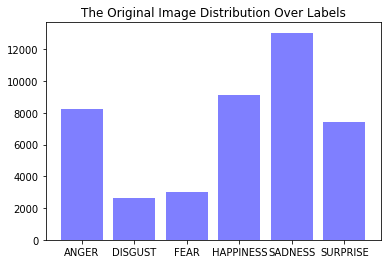

In [7]:
ab = Counter(origianl_label_set)
print("Original data ditribution = ", ab)
plt.bar(ab.keys(), ab.values(), align='center', color='b', alpha=0.5)

plt.title("The Original Image Distribution Over Labels")

In [8]:
from hashlib import sha1

hash_table = {}
dup_id_list = []
for i, each_data in enumerate(data_set):
    hash_num = sha1(each_data).hexdigest()
    if hash_num in hash_table:
        dup_id_list += [i]
        
    else:
        hash_table[hash_num] = i
        
        

In [9]:
data_no_duplicates = data_set.copy()
label_no_duplicates = origianl_label_set.copy()

dup_id_list.reverse()

for each in dup_id_list:
    del data_no_duplicates[each]
    del label_no_duplicates[each]


In [10]:
len(data_no_duplicates)

43239

In [11]:
len(label_no_duplicates)

43239

after removing duplicates data ditribution =  Counter({'SADNESS': 13040, 'HAPPINESS': 9113, 'ANGER': 8228, 'SURPRISE': 7417, 'FEAR': 2983, 'DISGUST': 2458})


<BarContainer object of 6 artists>

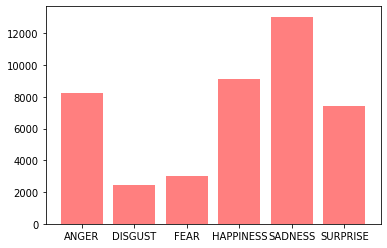

In [12]:
ab = Counter(label_no_duplicates)
print("after removing duplicates data ditribution = ", ab)
plt.bar(ab.keys(), ab.values(), align='center', color='r', alpha=0.5)

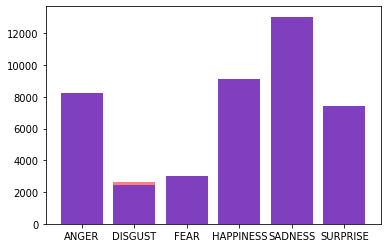

In [13]:
ab1 = Counter(label_no_duplicates)
ab2 = Counter(origianl_label_set)

fig, ax = plt.subplots()
ax.bar(ab.keys(), ab2.values(), align='center', color='r', alpha=0.5)
ax.bar(ab.keys(), np.array(list(ab2.values())) + (np.array(list(ab1.values()))-np.array(list(ab2.values()))), align='center', color='b', alpha=0.5)


plt.show()
plt.close()


In [14]:
label_enc = preprocessing.LabelEncoder()

label_enc.fit(label_no_duplicates)  
label_uniq_classes = label_enc.classes_
label_encoded_label_set = label_enc.transform(label_no_duplicates)


In [15]:
label_uniq_classes

array(['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE'],
      dtype='<U9')

In [16]:
x_train, x_test, y_train, y_test = train_test_split(data_no_duplicates, label_encoded_label_set, test_size=0.3, random_state=0, stratify=label_encoded_label_set, shuffle=True)

In [17]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.333333333333, random_state=0, stratify=y_test, shuffle=True)

In [18]:
Counter(y_train)

Counter({5: 5192, 4: 9128, 3: 6379, 0: 5759, 2: 2088, 1: 1721})

In [19]:
Counter(y_val)

Counter({0: 1646, 4: 2608, 3: 1823, 5: 1483, 1: 491, 2: 597})

In [20]:
Counter(y_test)

Counter({4: 1304, 2: 298, 5: 742, 0: 823, 3: 911, 1: 246})

In [4]:
def align_faces(data_list, lbl_list):

    detector = MTCNN()
    data_list_cp = data_list.copy()

    faces = []
    aligned_lbls = []
    non_aligned_lbls = []
   
    for i, each in enumerate(data_list):
        faces = detector.detect_faces(each)
        if len(faces) == 1  :
        
            aligned_img = alignment_procedure(data_list[i], faces[0]["keypoints"]["left_eye"], faces[0]["keypoints"]["right_eye"], faces[0]["keypoints"]["nose"])
            data_list_cp[i] = aligned_img
            
            aligned_lbls.append(lbl_list[i])
            
            
        else:
            non_aligned_lbls.append(lbl_list[i])
            
            
    return data_list_cp, Counter(aligned_lbls), Counter(non_aligned_lbls)
            
            

In [22]:
x_train_aligned, train_aligned_stat, train_non_aligned_stat = align_faces(x_train, y_train)

In [23]:
x_val_aligned, val_aligned_stat, val_non_aligned_stat = align_faces(x_val, y_val)

In [24]:
x_test_aligned, test_aligned_stat, test_non_aligned_stat = align_faces(x_test, y_test)

In [25]:
test_aligned_stat

Counter({4: 1279, 2: 292, 5: 707, 0: 794, 3: 896, 1: 236})

In [26]:
val_aligned_stat

Counter({0: 1595, 4: 2540, 3: 1782, 5: 1433, 1: 456, 2: 571})

In [27]:
train_aligned_stat

Counter({5: 4964, 4: 8933, 3: 6217, 0: 5560, 2: 2024, 1: 1647})

In [28]:
test_non_aligned_stat

Counter({4: 25, 5: 35, 0: 29, 1: 10, 3: 15, 2: 6})

In [29]:
val_non_aligned_stat

Counter({5: 50, 0: 51, 3: 41, 2: 26, 4: 68, 1: 35})

In [30]:
train_non_aligned_stat

Counter({4: 195, 5: 228, 0: 199, 1: 74, 2: 64, 3: 162})

In [5]:
def resize_faces(data_list, new_size = (96,96)):

   
    data_list_new = []
    
    for each in data_list:

        data_list_new.append(cv2.resize(each, new_size))
        
    return data_list_new

In [32]:
train_resized = resize_faces(x_train_aligned)

In [33]:
val_resized = resize_faces(x_val_aligned)

In [34]:
test_resized = resize_faces(x_test_aligned)

In [7]:
def normalize_faces(data_list):
    
    data_list_new = []
    img = None
    
    for each in data_list:
        
        #img = (each - np.min(each)) / float(np.max(each) - np.min(each))
        img = each/255.0
        
        data_list_new.append(img)
    
        
    return data_list_new


In [36]:
train_normalized = normalize_faces(train_resized)

In [37]:
val_normalized = normalize_faces(val_resized)

In [38]:
test_normalized = normalize_faces(test_resized)

In [39]:
import math
def add_noise(img_list, mode):
    
    noised_imgs = []
    for each in img_list:
        ab = random_noise(each, mode=mode, seed=0)
        noised_imgs.append(ab)
        
    return noised_imgs

In [40]:
#For Anger, class label = 0

b = [i for i, x in enumerate(y_train) if x == 0]
c = math.floor(len(b)*0.2)
print("Anger noised img amount = ",c*3)
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

aug_images = []
for i in aug_img_indexes:
    aug_images.append(train_normalized[i])
    
poisson_imgs = add_noise(aug_images, mode="poisson")
speckle_imgs = add_noise(aug_images, mode="speckle")
gaussian_imgs = add_noise(aug_images, mode="localvar")

anger_noised_imgs = poisson_imgs + speckle_imgs + gaussian_imgs
anger_noised_lbs = np.zeros(len(anger_noised_imgs))

Anger noised img amount =  3453


In [41]:
#For Disgust, class label = 1

b = [i for i, x in enumerate(y_train) if x == 1]
c = math.floor(len(b))
print("Disgust noised img amount = ",c*3)
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

aug_images = []
for i in aug_img_indexes:
    aug_images.append(train_normalized[i])
    
poisson_imgs = add_noise(aug_images, mode="poisson")
speckle_imgs = add_noise(aug_images, mode="speckle")
gaussian_imgs = add_noise(aug_images, mode="localvar")

disgust_noised_imgs = poisson_imgs + speckle_imgs + gaussian_imgs
disgust_noised_lbs = np.ones(len(disgust_noised_imgs))

Disgust noised img amount =  5163


In [42]:
#For Fear, class label = 2

b = [i for i, x in enumerate(y_train) if x == 2]
c = math.floor(len(b))
print("Fear noised img amount = ",c*3)
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

aug_images = []
for i in aug_img_indexes:
    aug_images.append(train_normalized[i])
    
poisson_imgs = add_noise(aug_images, mode="poisson")
speckle_imgs = add_noise(aug_images, mode="speckle")
gaussian_imgs = add_noise(aug_images, mode="localvar")

fear_noised_imgs = poisson_imgs + speckle_imgs + gaussian_imgs
fear_noised_lbs = np.ones(len(fear_noised_imgs))*2

Fear noised img amount =  6264


In [43]:
#For Happiness, class label = 3

b = [i for i, x in enumerate(y_train) if x == 3]
c = math.floor(len(b)*0.1)
print("Happiness noised img amount = ",c*3)
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

aug_images = []
for i in aug_img_indexes:
    aug_images.append(train_normalized[i])
    
poisson_imgs = add_noise(aug_images, mode="poisson")
speckle_imgs = add_noise(aug_images, mode="speckle")
gaussian_imgs = add_noise(aug_images, mode="localvar")

happiness_noised_imgs = poisson_imgs + speckle_imgs + gaussian_imgs
happiness_noised_lbs = np.ones(len(happiness_noised_imgs))*3

Happiness noised img amount =  1911


In [44]:
#For Sadness, class label = 4

b = [i for i, x in enumerate(y_train) if x == 4]
c = math.floor(len(b)*0.1)
print("Sadness noised img amount = ",c*3)
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

aug_images = []
for i in aug_img_indexes:
    aug_images.append(train_normalized[i])
    
poisson_imgs = add_noise(aug_images, mode="poisson")
speckle_imgs = add_noise(aug_images, mode="speckle")
gaussian_imgs = add_noise(aug_images, mode="localvar")

sadness_noised_imgs = poisson_imgs + speckle_imgs + gaussian_imgs
sadness_noised_lbs = np.ones(len(sadness_noised_imgs))*4

Sadness noised img amount =  2736


In [45]:
#For Surprise, class label = 5

b = [i for i, x in enumerate(y_train) if x == 5]
c = math.floor(len(b)*0.2)
print("Surprise noised img amount = ",c*3)
np.random.seed(0)
aug_img_indexes = np.random.choice(b,c)
aug_img_indexes

aug_images = []
for i in aug_img_indexes:
    aug_images.append(train_normalized[i])
    
poisson_imgs = add_noise(aug_images, mode="poisson")
speckle_imgs = add_noise(aug_images, mode="speckle")
gaussian_imgs = add_noise(aug_images, mode="localvar")

surprise_noised_imgs = poisson_imgs + speckle_imgs + gaussian_imgs
surprise_noised_lbs = np.ones(len(surprise_noised_imgs))*5

Surprise noised img amount =  3114


In [46]:
final_x_train = train_normalized+anger_noised_imgs+disgust_noised_imgs+fear_noised_imgs+happiness_noised_imgs+sadness_noised_imgs+surprise_noised_imgs   

In [47]:
final_y_train = np.concatenate((y_train, anger_noised_lbs, disgust_noised_lbs, fear_noised_lbs, happiness_noised_lbs, sadness_noised_lbs, surprise_noised_lbs )) 

In [48]:
#shuffling after adding noised images

temp = list(zip(final_x_train, final_y_train))

import random
random.seed(0)

random.shuffle(temp)
shuffled_x_train, shuffled_y_train = zip(*temp)

shuffled_x_train, shuffled_y_train = np.array(shuffled_x_train), np.array(shuffled_y_train)



In [49]:
#saving pre processed data

with open('train_x.npy', 'wb') as f:
    np.save(f, shuffled_x_train)
with open('train_y.npy', 'wb') as f:
    np.save(f, shuffled_y_train.astype(int))
    
with open('val_x.npy', 'wb') as f:
    np.save(f, np.array(val_normalized))
with open('val_y.npy', 'wb') as f:
    np.save(f, y_val.astype(int))
    
with open('test_x.npy', 'wb') as f:
    np.save(f, np.array(test_normalized))
with open('test_y.npy', 'wb') as f:
    np.save(f, y_test.astype(int))

In [ ]:
#pre-processing new test data


In [8]:
root_dir = 'assignment_2_MLD_qmul/'
class_folders = [directory for directory in os.listdir(root_dir) if os.path.isdir(root_dir+directory)]
print(class_folders)

data_set = []
origianl_label_set = []

temp_data = []
for each in class_folders:
    temp_data =  [cv2.cvtColor(cv2.imread((root_dir+each+"/"+name)), cv2.COLOR_BGR2RGB) for name in os.listdir((root_dir+each+"/")) if name.endswith(".jpg")]
    data_set += temp_data
    origianl_label_set += [each]*len(temp_data)

['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']


In [9]:
len(data_set)

26124

In [10]:
len(origianl_label_set)

26124

Original data ditribution =  Counter({'SADNESS': 11939, 'SURPRISE': 7244, 'ANGER': 3427, 'DISGUST': 1394, 'FEAR': 1362, 'HAPPINESS': 758})


Text(0.5, 1.0, 'The New Test Image Distribution Over Labels')

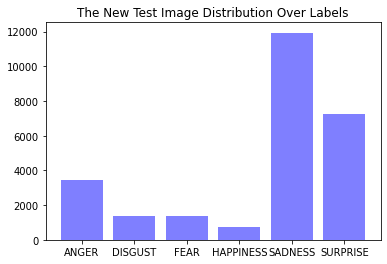

In [11]:
ab = Counter(origianl_label_set)
print("Original data ditribution = ", ab)
plt.bar(ab.keys(), ab.values(), align='center', color='b', alpha=0.5)

plt.title("The New Test Image Distribution Over Labels")

In [12]:
label_enc = preprocessing.LabelEncoder()

label_enc.fit(origianl_label_set)  
label_uniq_classes = label_enc.classes_
label_encoded_label_set = label_enc.transform(origianl_label_set)

In [13]:
label_uniq_classes

array(['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE'],
      dtype='<U9')

In [14]:
x_test_new_aligned, test_new_aligned_stat, test_new_non_aligned_stat = align_faces(data_set, label_encoded_label_set)

In [15]:
test_new_aligned_stat

Counter({0: 3398, 1: 1392, 2: 1266, 3: 741, 4: 11056, 5: 7029})

In [16]:
test_new_non_aligned_stat

Counter({0: 29, 1: 2, 2: 96, 3: 17, 4: 883, 5: 215})

In [17]:
test_new_resized = resize_faces(x_test_new_aligned)

In [18]:
test_new_normalized = normalize_faces(test_new_resized)

In [19]:
with open('test_new_x.npy', 'wb') as f:
    np.save(f, np.array(test_new_normalized))
with open('test_new_y.npy', 'wb') as f:
    np.save(f, label_encoded_label_set.astype(int))

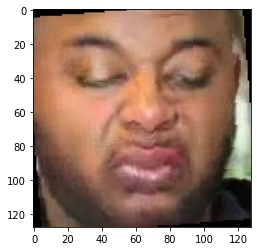

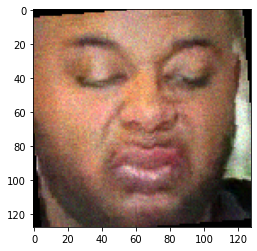

In [61]:
ab1 = random_noise(x_train_aligned[0], mode='poisson', seed=0)
imgplot = plt.imshow(x_train_aligned[0])
plt.show()
imgplot = plt.imshow(ab1)
plt.show()

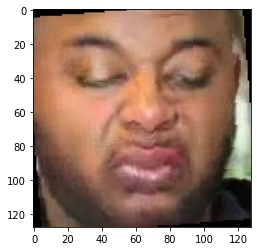

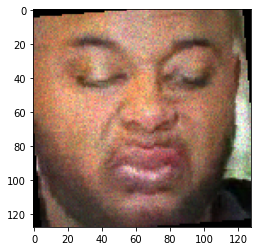

In [62]:
ab2 = random_noise(x_train_aligned[0], mode='speckle', seed=0)
imgplot = plt.imshow(x_train_aligned[0])
plt.show()
imgplot = plt.imshow(ab2)
plt.show()

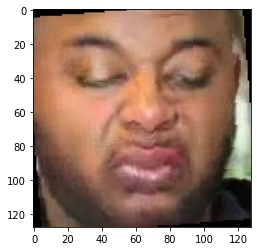

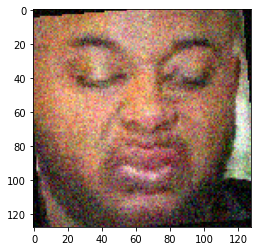

In [63]:
ab3 = random_noise(x_train_aligned[0], mode='localvar', seed=0)
imgplot = plt.imshow(x_train_aligned[0])
plt.show()
imgplot = plt.imshow(ab3)
plt.show()

In [71]:
(ab2==ab3).all()

False

Text(0.5, 1.0, 'Train Data Distribution After Augmentation')

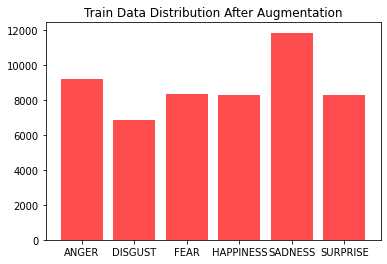

In [6]:
temp_dict = {"ANGER":9212,"DISGUST":6884,"FEAR":8352, "HAPPINESS":8290, "SADNESS":11864, "SURPRISE":8306}



plt.bar(temp_dict.keys(), temp_dict.values(), align='center', color='r', alpha=0.7)
plt.title("Train Data Distribution After Augmentation")

Text(0.5, 1.0, 'Test Data Distribution After Augmentation')

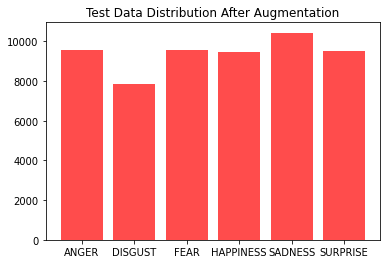

In [106]:
temp_dict = {"ANGER":9543,"DISGUST":7868,"FEAR":9544, "HAPPINESS":9477, "SADNESS":10432, "SURPRISE":9492}



plt.bar(temp_dict.keys(), temp_dict.values(), align='center', color='r', alpha=0.7)
plt.title("Test Data Distribution After Augmentation")

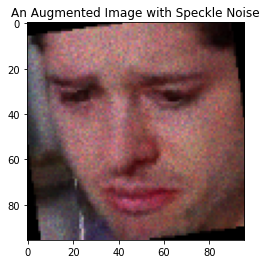

In [178]:
ab2 = random_noise(train_normalized[34], mode='speckle', seed=0)
imgplot = plt.imshow(ab2)
plt.title("An Augmented Image with Speckle Noise")
plt.show()

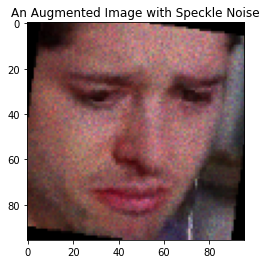

In [179]:
imgplot = plt.imshow(ab2[:, ::-1, :])
plt.title("An Augmented Image with Speckle Noise")
plt.show()


Scatter plots for Flavanoids, Colour Intensity and Proline features



Text(0.5, 1.0, 'Aligned, Rescaled and Normalized Image')

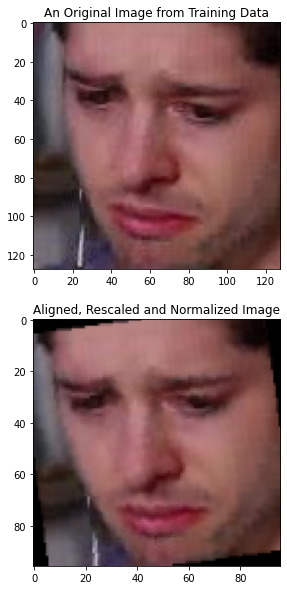

In [174]:
print("\nScatter plots for Flavanoids, Colour Intensity and Proline features\n")
fig, axes = plt.subplots(2, 1, figsize=(10,10))

axes[0].imshow(x_train[34])
axes[0].set_title("An Original Image from Training Data")
axes[1].imshow(train_normalized[34])
axes[1].set_title("Aligned, Rescaled and Normalized Image")
#axes[2].imshow(ab2)




Scatter plots for Flavanoids, Colour Intensity and Proline features



Text(0.5, 1.0, 'An Image Labeled as Surprise')

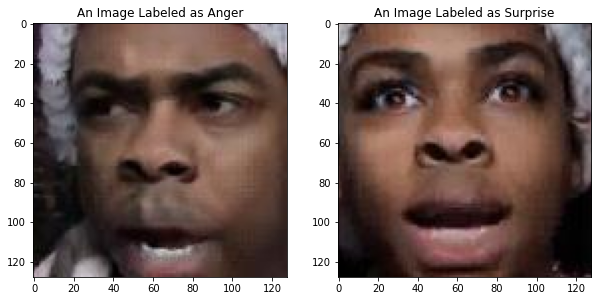

In [182]:
a1 = cv2.cvtColor(cv2.imread("anger.jpg"), cv2.COLOR_BGR2RGB)
a2 = cv2.cvtColor(cv2.imread("surprise.jpg"), cv2.COLOR_BGR2RGB)

axes[0].imshow(a1)
axes[0].set_title("An Image Labeled as Anger")
axes[1].imshow(a2)
axes[1].set_title("An Image Labeled as Surprise")
#axes[2].imshow(ab2)
